# California Housing Model

In [1]:
from sklearn.datasets import fetch_california_housing

In [2]:
housing = fetch_california_housing(as_frame=True)
df = housing.frame
df.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   MedInc       20640 non-null  float64
 1   HouseAge     20640 non-null  float64
 2   AveRooms     20640 non-null  float64
 3   AveBedrms    20640 non-null  float64
 4   Population   20640 non-null  float64
 5   AveOccup     20640 non-null  float64
 6   Latitude     20640 non-null  float64
 7   Longitude    20640 non-null  float64
 8   MedHouseVal  20640 non-null  float64
dtypes: float64(9)
memory usage: 1.4 MB


In [4]:
df["Population"].value_counts()

Population
891.0     25
761.0     24
1227.0    24
1052.0    24
850.0     24
          ..
2141.0     1
5546.0     1
3186.0     1
3590.0     1
6912.0     1
Name: count, Length: 3888, dtype: int64

In [5]:
df.describe()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
count,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,3.870671,28.639486,5.429000,1.096675,1425.476744,3.070655,35.631861,-119.569704,2.068558
std,1.899822,12.585558,2.474173,0.473911,1132.462122,10.386050,2.135952,2.003532,1.153956
min,0.499900,1.000000,0.846154,0.333333,3.000000,0.692308,32.540000,-124.350000,0.149990
25%,2.563400,18.000000,4.440716,1.006079,787.000000,2.429741,33.930000,-121.800000,1.196000
50%,3.534800,29.000000,5.229129,1.048780,1166.000000,2.818116,34.260000,-118.490000,1.797000
75%,4.743250,37.000000,6.052381,1.099526,1725.000000,3.282261,37.710000,-118.010000,2.647250
max,15.000100,52.000000,141.909091,34.066667,35682.000000,1243.333333,41.950000,-114.310000,5.000010


The hist() method relies on Matplotlib, which in turn relies on a user-specified graphical backend to draw on your screen. 
So before you can plot anything, you need to specify which backend Matplotlib should use. 

The simplest option is to use Jupyter’s magic command %matplotlib inline. 
This tells Jupyter to set up Matplotlib so it uses Jupyter’s own backend. Plots are then rendered within the notebook itself.

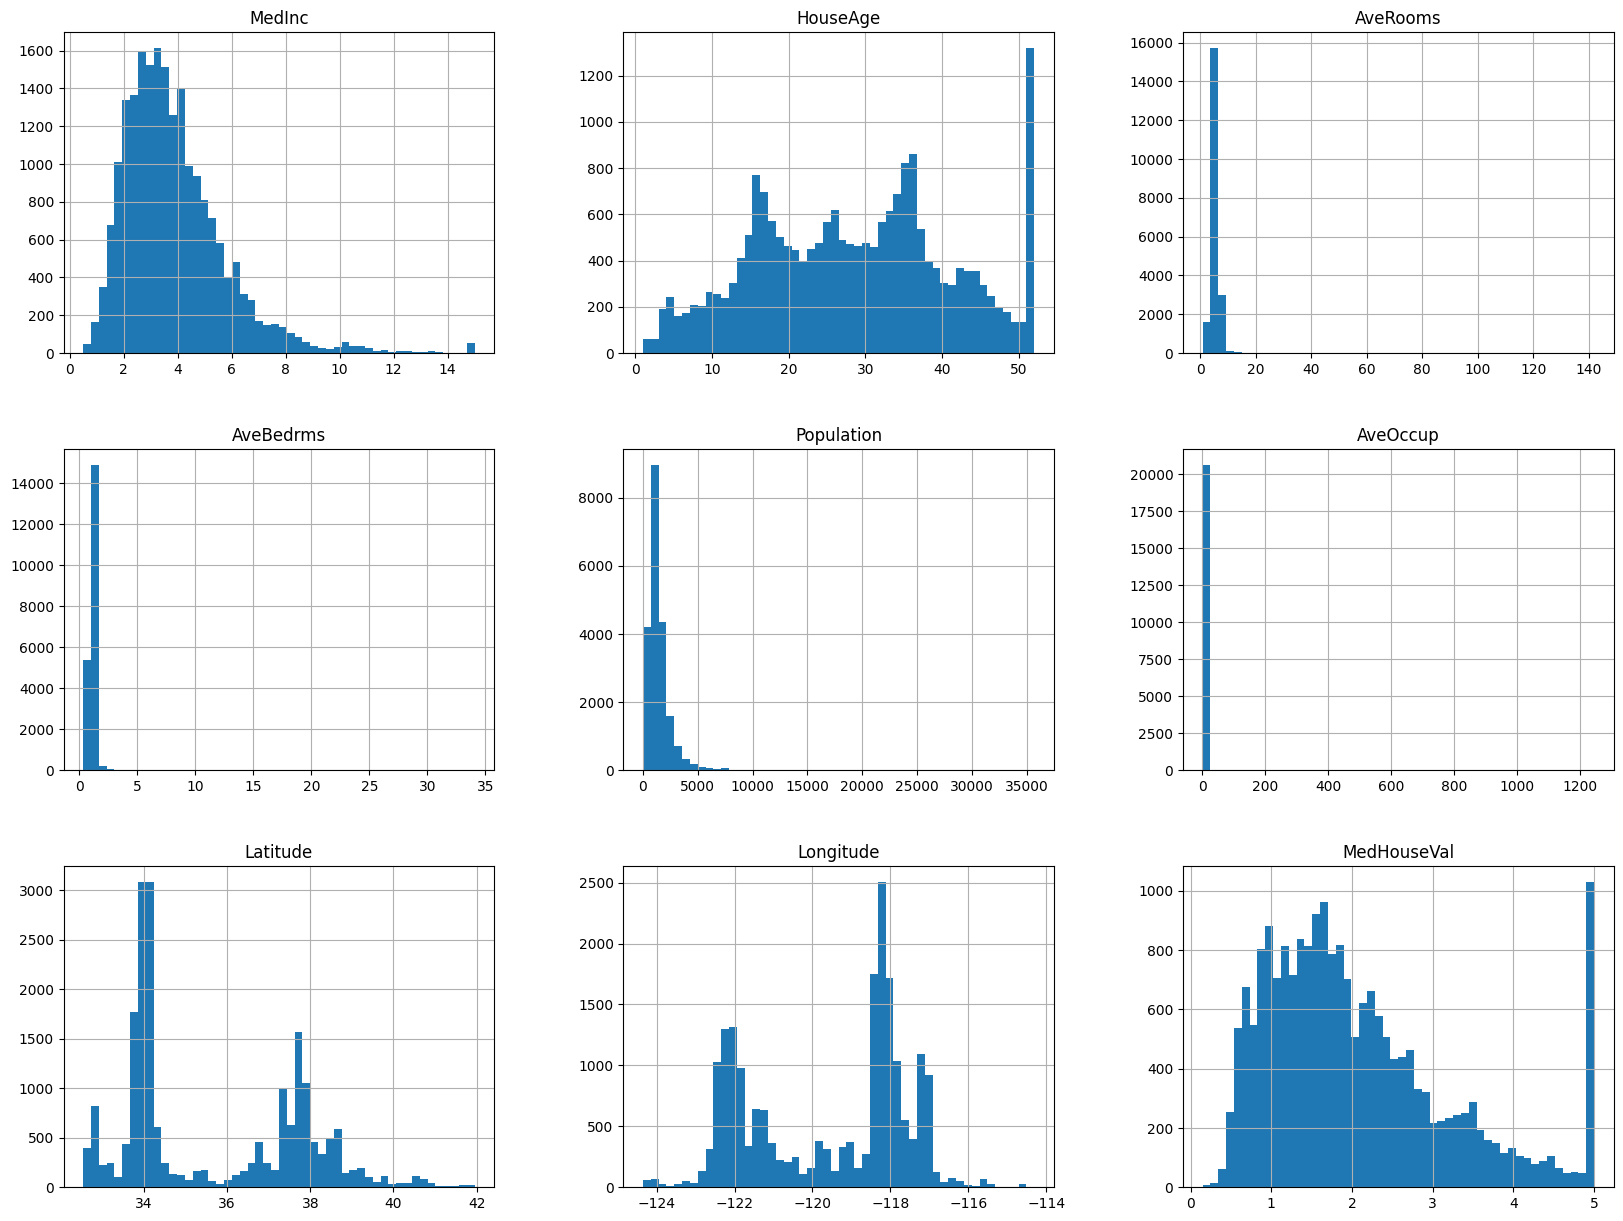

In [6]:
%matplotlib inline

import matplotlib.pyplot as plt

df.hist(bins=50, figsize=(20, 15))
plt.show()

### Observations from the above hisograms
 - The median income attribute is not expressed in US dollars. The data has been scaled and capped at 15 for higher median incomes and at 0.5 at lower median incomes.
 - Housing median age `HouseAge` and median house value `MedHouseVal` are also capped.
 - The attributes have very different scales
 - Many histograms are tail heavy, that is, they extend much farther to the right of the median than to the left.

## Creating Test Set

In [7]:
# Function to create test set and train set
import numpy as np

def split_train_test(data, test_ratio):
    shuffled_indices = np.random.permutation(len(data))
    test_set_size = int(len(data)*test_ratio)
    
    test_indices = shuffled_indices[:test_set_size]
    train_indices = shuffled_indices[test_set_size:]

    return data.iloc[train_indices], data.iloc[test_indices]

In [8]:
# Scikit function to split dataset

from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(df, test_size=0.2, random_state=42)
# the random_state is the seed value that ensres the same test set is loaded everytime this function is run to avoid model overfitting
print(len(train_set), "train + ", len(test_set), "test")

16512 train +  4128 test


If we consider median income `MedInc` as an important attribute to predict median housing prices, we need to ensure that the test set is representative of the various categories of incomes in the whole dataset.

Since, the median income is a continuous numerical attribute, we first need to create an income category attribute.

The following code creates an income category attribute by dividing the median income by 1.5 (to limit the number of income categories), and rounding up using ceil (to have discrete categories), and then merging all the categories greater than 5 into category 5

In [9]:
df["IncomeCat"] = np.ceil(df["MedInc"]/1.5)
df["IncomeCat"] = df["IncomeCat"].where(df["IncomeCat"] < 5, 5.0)

### Stratified sampling based on the income category

#### **Stratified sampling**
The population is divided into homogeneous subgroups called strata, and the right number of instances is sampled from each stratum to guarantee that the test set is representative of the overall population

It is important to have a sufficient number of instances in your dataset for each stratum, or else the estimate of the stratum’s importance may be biased. This means that you should not have too many strata, and each stratum should be large enough.

In [10]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits = 1, test_size = 0.2, random_state = 42)

for train_index, test_index in split.split(df, df["IncomeCat"]):
    strat_train_set = df.loc[train_index]
    strat_test_set = df.loc[test_index]

df["IncomeCat"].value_counts()/len(df)

IncomeCat
3.0    0.350581
2.0    0.318847
4.0    0.176308
5.0    0.114438
1.0    0.039826
Name: count, dtype: float64

Now you should remove the `IncomeCat` attribute so the data is back to its original state

In [11]:
for set in (strat_train_set, strat_test_set):
    set.drop(['IncomeCat'], axis=1, inplace=True)

## Gaining Insights

In [12]:
# Creating a copy of train set

housing = strat_train_set.copy()

### Visualizing Geographical Data

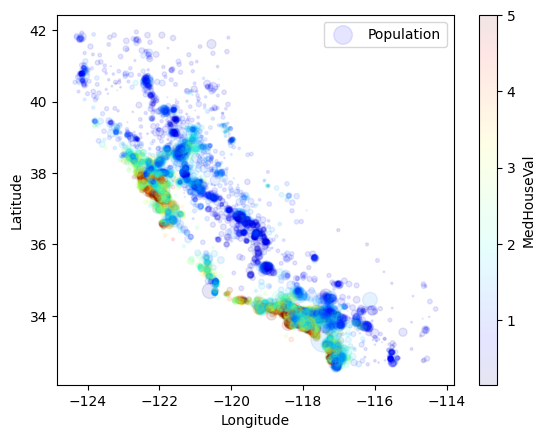

In [13]:
housing.plot(kind="scatter", x="Longitude", y="Latitude", alpha=0.1,
            s=housing["Population"]/100, label="Population",
            c="MedHouseVal", cmap=plt.get_cmap("jet"), colorbar=True)
plt.legend()

Option `s`: radius of each circle represents district's population

Option `c`: color represents price

cmap=jet: predefined color map which ranges from blue(low values) to red(high values)

## Finding Correlations

Pearson's r: Standard Correlation Coefficient
(Computed between every pair of attributes)

In [14]:
corr_matrix = housing.corr()

print(corr_matrix)

               MedInc  HouseAge  AveRooms  AveBedrms  Population  AveOccup  \
MedInc       1.000000 -0.111315  0.311528  -0.058559    0.002421  0.021815   
HouseAge    -0.111315  1.000000 -0.147184  -0.075162   -0.298737  0.015031   
AveRooms     0.311528 -0.147184  1.000000   0.862315   -0.074665 -0.005316   
AveBedrms   -0.058559 -0.075162  0.862315   1.000000   -0.068061 -0.005791   
Population   0.002421 -0.298737 -0.074665  -0.068061    1.000000  0.076232   
AveOccup     0.021815  0.015031 -0.005316  -0.005791    0.076232  1.000000   
Latitude    -0.075146  0.005737  0.107665   0.070133   -0.115290  0.005426   
Longitude   -0.019615 -0.105823 -0.028374   0.012883    0.108071 -0.000415   
MedHouseVal  0.687151  0.114146  0.146255  -0.043294   -0.026882 -0.021991   

             Latitude  Longitude  MedHouseVal  
MedInc      -0.075146  -0.019615     0.687151  
HouseAge     0.005737  -0.105823     0.114146  
AveRooms     0.107665  -0.028374     0.146255  
AveBedrms    0.070133   0.0

In [15]:
corr_matrix['MedHouseVal'].sort_values(ascending=False)

MedHouseVal    1.000000
MedInc         0.687151
AveRooms       0.146255
HouseAge       0.114146
AveOccup      -0.021991
Population    -0.026882
AveBedrms     -0.043294
Longitude     -0.047466
Latitude      -0.142673
Name: MedHouseVal, dtype: float64

The median house value goes up with median income

Sometimes correlation coefficient may miss out on non-linear relationships because it only measures linear correlations

**Using Pandas' scatter_matrix function to plot every numerical attribute against every other numerical attribute**

array([[<Axes: xlabel='MedHouseVal', ylabel='MedHouseVal'>,
        <Axes: xlabel='MedInc', ylabel='MedHouseVal'>,
        <Axes: xlabel='AveRooms', ylabel='MedHouseVal'>,
        <Axes: xlabel='HouseAge', ylabel='MedHouseVal'>],
       [<Axes: xlabel='MedHouseVal', ylabel='MedInc'>,
        <Axes: xlabel='MedInc', ylabel='MedInc'>,
        <Axes: xlabel='AveRooms', ylabel='MedInc'>,
        <Axes: xlabel='HouseAge', ylabel='MedInc'>],
       [<Axes: xlabel='MedHouseVal', ylabel='AveRooms'>,
        <Axes: xlabel='MedInc', ylabel='AveRooms'>,
        <Axes: xlabel='AveRooms', ylabel='AveRooms'>,
        <Axes: xlabel='HouseAge', ylabel='AveRooms'>],
       [<Axes: xlabel='MedHouseVal', ylabel='HouseAge'>,
        <Axes: xlabel='MedInc', ylabel='HouseAge'>,
        <Axes: xlabel='AveRooms', ylabel='HouseAge'>,
        <Axes: xlabel='HouseAge', ylabel='HouseAge'>]], dtype=object)

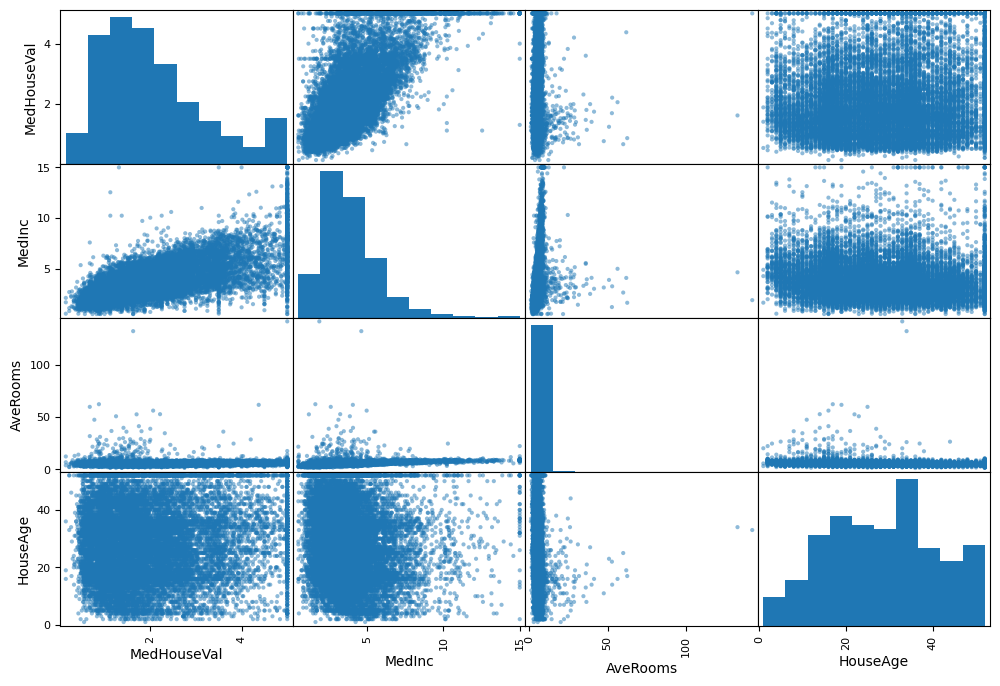

In [16]:
from pandas.plotting import scatter_matrix

attributes = ["MedHouseVal", "MedInc", "AveRooms", "HouseAge"]

scatter_matrix(housing[attributes], figsize=(12,8))

<Axes: xlabel='MedInc', ylabel='MedHouseVal'>

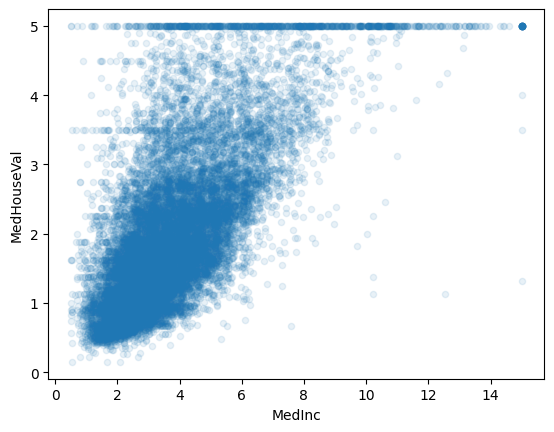

In [17]:
housing.plot(kind="scatter", x="MedInc", y="MedHouseVal", alpha=0.1)

### Observations
- The correlation in the above plot is very strong.
- The horizontal line at the top denotes the price cap at %50,000
- Other less obvious straight lines:
  
  - at around $45,000
    
  - at around $35,000
    
  - more faint ones at around $14,000  and  $22,000

## Experimenting with Attribute Combinations

We can create multiple attributes using the already existing ones in the dataset to better understand about the data

In [18]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
Index: 16512 entries, 12655 to 19773
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   MedInc       16512 non-null  float64
 1   HouseAge     16512 non-null  float64
 2   AveRooms     16512 non-null  float64
 3   AveBedrms    16512 non-null  float64
 4   Population   16512 non-null  float64
 5   AveOccup     16512 non-null  float64
 6   Latitude     16512 non-null  float64
 7   Longitude    16512 non-null  float64
 8   MedHouseVal  16512 non-null  float64
dtypes: float64(9)
memory usage: 1.3 MB


In [19]:
housing["RoomsPerHousehold"] = housing["AveRooms"]/housing["AveOccup"]
housing["BedroomsPerHouse"] = housing["AveBedrms"]/housing["AveRooms"]
housing["PopulationPerHoushold"] = housing["Population"]/housing["AveOccup"]

housing.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal,RoomsPerHousehold,BedroomsPerHouse,PopulationPerHoushold
12655,2.1736,29.0,5.485836,1.128895,2237.0,3.168555,38.52,-121.46,0.721,1.731337,0.205784,706.0
15502,6.3373,7.0,6.927083,1.113281,2015.0,2.623698,33.09,-117.23,2.796,2.640199,0.160714,768.0
2908,2.8750,44.0,5.393333,1.033333,667.0,2.223333,35.37,-119.04,0.827,2.425787,0.191595,300.0
14053,2.2264,24.0,3.886128,1.074534,898.0,1.859213,32.75,-117.13,1.125,2.090200,0.276505,483.0
20496,4.4964,27.0,6.096552,1.113793,1837.0,3.167241,34.28,-118.70,2.383,1.924878,0.182692,580.0


In [20]:
corr_matrix = housing.corr()
corr_matrix["MedHouseVal"].sort_values(ascending=False)

MedHouseVal              1.000000
MedInc                   0.687151
RoomsPerHousehold        0.199420
AveRooms                 0.146255
HouseAge                 0.114146
PopulationPerHoushold    0.064590
AveOccup                -0.021991
Population              -0.026882
AveBedrms               -0.043294
Longitude               -0.047466
Latitude                -0.142673
BedroomsPerHouse        -0.259934
Name: MedHouseVal, dtype: float64

# Prepare the data for Machine Learning algorithms

In [21]:
housing = strat_train_set.drop("MedHouseVal", axis=1)
housing_labels = strat_train_set["MedHouseVal"].copy()

## Data Cleaning

In [22]:
housing.isna()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
12655,False,False,False,False,False,False,False,False
15502,False,False,False,False,False,False,False,False
2908,False,False,False,False,False,False,False,False
14053,False,False,False,False,False,False,False,False
20496,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...
15174,False,False,False,False,False,False,False,False
12661,False,False,False,False,False,False,False,False
19263,False,False,False,False,False,False,False,False
19140,False,False,False,False,False,False,False,False


If in case, any attribute of the dataset has missing value we can deal with that using an `Imputer` instance from `sklearn` by specify that we need to replace the attribute's missing value with the median of that attribute.

```python
from sklearn.preprocessing import Imputer

imputer = Imputer(strategy="median")

imputer.fit(housing)
```

The `imputer` computes the median of each attribute in the dataset and store the result in it's *statistics_* instance variable

```python
imputer.statistics_
```
Now we can use this imputer to transform the training set by replacing missing values by the learned medians.

```python
X = imputer.transform(housing)
```
The result is a plain Numpy array containing the transformed features.

## Custom Transformer

In [23]:
from sklearn.base import BaseEstimator, TransformerMixin

rooms_ix, bedrooms_ix, population_ix, household_ix = 3, 4, 5, 6

class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_room = True):
        self.add_bedrooms_per_room = add_bedrooms_per_room

    def fit(self, X, y=None):
        return self # nothing else to do

    def transform(self, X, y=None):
        rooms_per_household = X[:, rooms_ix]/ X[:, household_ix]
        population_per_household = X[:, population_ix]/ X[:, household_ix]

        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, bedrooms_ix]/ X[:, rooms_ix]

            return np.c_[X, rooms_per_household, population_per_household, bedrooms_per_room]
        else:
            return np.c_[X, rooms_per_household, population_per_household]

In [24]:
attribute_adder = CombinedAttributesAdder(add_bedrooms_per_room=False)
housing_extra_attributes = attribute_adder.transform(housing.values)

### **Custom transformer to handle pandas dataframe**

In [25]:
from sklearn.base import BaseEstimator, TransformerMixin

class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names].values

## Transformation Pipelines

In [26]:
!pip install sklearn_features

In [27]:
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn_features.transformers import DataFrameSelector
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

num_attributes = list[housing]

# A pipeline for numerical attributes
num_pipeline = Pipeline([
    ('selector', DataFrameSelector(num_attributes)),
    ('imputer', SimpleImputer(strategy='median')),
    ('attributes_adder', CombinedAttributesAdder()),
    ('standard_scaler', StandardScaler())
])

pipeline = FeatureUnion(transformer_list = [
    ("num_pipeline", num_pipeline)
])

In [28]:
housing_prepared = pipeline.fit_transform(housing)
housing_prepared

array([[-0.8936472 ,  0.02756357,  0.01739526, ..., -0.11681412,
        -0.01593814,  0.60663793],
       [ 1.292168  , -1.72201763,  0.56925554, ...,  0.20673145,
        -0.02572897,  0.44412683],
       [-0.52543365,  1.22045984, -0.01802432, ..., -0.12365926,
        -0.07993607, -0.65855765],
       ...,
       [-0.36547546,  1.53856552, -0.5092404 , ..., -0.43009043,
        -0.05878152, -0.82041642],
       [ 0.16826095, -1.1653327 ,  0.32814891, ..., -0.04877265,
        -0.07967444, -0.28169931],
       [-0.390569  , -0.13148926,  0.01407228, ..., -0.19983894,
        -0.02545019, -0.74460229]])

In [29]:
housing_prepared.shape


(16512, 11)

In [30]:
housing.shape

(16512, 8)

# Select and Train a Model

## Training a Linear Regrsion model

In [31]:
from sklearn.linear_model import LinearRegression

model = LinearRegression()
model.fit(housing_prepared, housing_labels)

LinearRegression()

In [32]:
sample_data = housing.iloc[:5]
sample_labels = housing_labels.iloc[:5]

sample_data_prepared = pipeline.transform(sample_data)
print("Predictions: \t", model.predict(sample_data_prepared))

Predictions: 	 [1.03299741 2.90831239 1.64299455 1.62439762 2.52590158]


In [33]:
print("Labels: \t", list(sample_labels))

Labels: 	 [0.721, 2.796, 0.827, 1.125, 2.383]


Computing the model's RMSE(Root Mean Squared Error)

In [34]:
from sklearn.metrics import mean_squared_error

housing_predictions = model.predict(housing_prepared)
mse = mean_squared_error(housing_labels, housing_predictions)
print(mse)
rmse = np.sqrt(mse)
rmse

0.5210893095738447


0.7218651602438261

## Training a Decision Tree Regressor

In [35]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor()
tree_reg.fit(housing_prepared, housing_labels)

DecisionTreeRegressor()

In [36]:
housing_predictions = tree_reg.predict(housing_prepared)

tree_mse = mean_squared_error(housing_labels, housing_predictions)
tree_rmse = np.sqrt(tree_mse)
print(tree_mse)
tree_rmse

9.196688726686335e-32


3.03260428125503e-16

## Evaluating using Cross-Validation

Using Scikit-learn's *K-fold Cross Validation* that randomly splits the training set into 10 distincts subsets called *folds*, then trains and evaluates the *Decision Tree* model 10 times, picking different fold for evaluation every time and training on the other 9 folds.

In [37]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(tree_reg, housing_prepared, housing_labels,
                        scoring="neg_mean_squared_error", cv=10)
rmse_scores = np.sqrt(-scores)

In [38]:
def display_scores(scores):
    print("Scores: ", scores)
    print("Mean: ", scores.mean())
    print("Standard Deviation: ", scores.std())

display_scores(rmse_scores)

Scores:  [0.7778024  0.74376915 0.71378883 0.7712709  0.73276429 0.73934716
 0.74397772 0.74219787 0.69238454 0.76024705]
Mean:  0.741754990426579
Standard Deviation:  0.024141111743572807


In [39]:
# Computing the scores for linear regression

linear_scores = cross_val_score(model, housing_prepared, housing_labels,
                               scoring="neg_mean_squared_error", cv=10)

lin_rmse_scores = np.sqrt(-linear_scores)
display_scores(lin_rmse_scores)

Scores:  [0.74122284 0.70200679 0.70374968 0.73901956 0.71472864 0.75445188
 0.74132046 0.80638561 0.70100858 0.73581152]
Mean:  0.7339705576956079
Standard Deviation:  0.030316085779568142


## Training a RandomForestRegressor

In [40]:
from sklearn.ensemble import RandomForestRegressor

forest_reg = RandomForestRegressor()
forest_reg.fit(housing_prepared, housing_labels)

forest_scores = cross_val_score(forest_reg, housing_prepared, housing_labels,
                               scoring="neg_mean_squared_error", cv=10)
forest_rmse_scores = np.sqrt(-forest_scores)
display_scores(forest_rmse_scores)

Scores:  [0.54036552 0.50329407 0.47056889 0.5240261  0.4819942  0.51999501
 0.54508454 0.51114103 0.49022977 0.54274967]
Mean:  0.5129448798157391
Standard Deviation:  0.02492330244272601


## Saving our models

In [41]:
import joblib

joblib.dump(model, "linear_model.pkl")

['linear_model.pkl']

In [42]:
joblib.dump(tree_reg, "decision_tree_model.pkl")

['decision_tree_model.pkl']

In [43]:
joblib.dump(forest_reg, "forest_model.pkl")

['forest_model.pkl']

# Fine Tuning Model

## Grid Search

Grid Search evaluates all the possible combinatins of hyperparameter values, using cross-validation.

In [44]:
from sklearn.model_selection import GridSearchCV

param_grid = [
    {'n_estimators': [3,10,30],
    'max_features': [2,4,6,8]},
    {'bootstrap': [False],
    'n_estimators': [3,10],
    'max_features': [2,3,4]}
]

grid_search = GridSearchCV(forest_reg, param_grid, cv=5, scoring='neg_mean_squared_error')

grid_search.fit(housing_prepared, housing_labels)

GridSearchCV(cv=5, estimator=RandomForestRegressor(),
             param_grid=[{'max_features': [2, 4, 6, 8],
                          'n_estimators': [3, 10, 30]},
                         {'bootstrap': [False], 'max_features': [2, 3, 4],
                          'n_estimators': [3, 10]}],
             scoring='neg_mean_squared_error')

In [48]:
grid_search.best_params_

{'max_features': 4, 'n_estimators': 30}

The `param_grid` tells scikit-learn to first evaluate `3 X 4 = 12` combinations of `n_estimators` and `max_features` hyperparameter values specified in the first dict.

Then try all `2 X 3 = 6` combinations of hyperparameter values in the second dict, but this time with the `bootstrap` hyperparameter set to `False`.

Therefore, the grid search will explore `12 + 6 = 18` combinations of `RandomForestRegressor` hyperparameter values, and it will train each model five times(beacuse *cv* is set to 5).

Hence there will be `18 X 5 = 90` rounds of training!

**Getting the best estimator directly**

In [46]:
grid_search.best_estimator_
RandomForestRegressor(
    bootstrap=True,
    criterion='mse',
    max_depth=None,
    max_features=6,
    max_leaf_nodes=None,
    min_samples_leaf=1,
    min_samples_split=2,
    min_weight_fraction_leaf=0.0,
    n_estimators=30,
    n_jobs=1,
    oob_score=False,
    random_state=None,
    verbose=0,
    warm_start=False
)

cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

0.6559369981487758 {'max_features': 2, 'n_estimators': 3}
0.5658304681993035 {'max_features': 2, 'n_estimators': 10}
0.5348815774175723 {'max_features': 2, 'n_estimators': 30}
0.6165094663834823 {'max_features': 4, 'n_estimators': 3}
0.5419365026014674 {'max_features': 4, 'n_estimators': 10}
0.5190079172994279 {'max_features': 4, 'n_estimators': 30}
0.6110697880969281 {'max_features': 6, 'n_estimators': 3}
0.542666817204931 {'max_features': 6, 'n_estimators': 10}
0.5220781688242424 {'max_features': 6, 'n_estimators': 30}
0.6140755506867901 {'max_features': 8, 'n_estimators': 3}
0.5415017422979936 {'max_features': 8, 'n_estimators': 10}
0.5220231387218195 {'max_features': 8, 'n_estimators': 30}
0.6383977229707738 {'bootstrap': False, 'max_features': 2, 'n_estimators': 3}
0.5504882966209316 {'bootstrap': False, 'max_features': 2, 'n_estimators': 10}
0.6136125552672314 {'bootstrap': False, 'max_features': 3, 'n_estimators': 3}
0.5383966838893406 {'bootstrap': False, 'max_features': 3, 'n_

## Randomized Search

Used preferrably when hyperparameter *search space* is large.

It evaluates a given number of random combinations by selecting a random value for each hyperparameter at every iteration.

## Ensemble Methods

Another way to fine-tune our system is try to combine the models that perform the best.

The group(or ensemble) will often perform better than the best individual model, especially if the individual models make very different type of errors.

# Analyzing the best models and their errors